In [1]:
# 初期設定

!pip install scipy

sample_len = 2 # seconds
sampling_rate = 44100
data_len = sample_len * sampling_rate

     |████████████████████████████████| 34.5 MB 16.7 MB/s eta 0:00:01   |███████▌                        | 8.1 MB 9.1 MB/s eta 0:00:03     |███████████████                 | 16.1 MB 13.1 MB/s eta 0:00:02
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# サンプリングレイヤー

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# エンコーダー    

latent_dim = 2
latent_vector_size = int(data_len / 3 / 3 / 2 / 2)

encoder_inputs = keras.Input(shape=(data_len, 1))
x = layers.Conv1D(4, 3, activation="relu", strides=3, padding="same")(encoder_inputs)
x = layers.Conv1D(8, 3, activation="relu", strides=3, padding="same")(x)
x = layers.Conv1D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# デコーダー

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(latent_vector_size * 4, activation="relu")(latent_inputs)
x = layers.Reshape((latent_vector_size, 4))(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(8, 3, activation="relu", strides=3, padding="same")(x)
x = layers.Conv1DTranspose(4, 3, activation="relu", strides=3, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# VAE

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def predict(self, x):
        z_mean, _, _ = self.encoder.predict(x)
        y = self.decoder.predict(z_mean)
        return y

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 441000, 1)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88200, 4)     16          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 17640, 4)     52          ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 3528, 4)      52          ['conv1d_1[0][0]']               
                                                                                            

In [3]:
# データ作成

from scipy.io.wavfile import read
import glob

files = glob.glob("../data/wav44100/*")
#files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
raw_data_list = [read(file)[1] for file in files]
    
input_data_array = np.zeros((0, data_len), dtype=np.int16)
for raw_data in raw_data_list:
    tmp = [raw_data[i:i + data_len] for i in range(0, len(raw_data) - data_len, data_len)]
    input_data_array = np.vstack((input_data_array, np.array(tmp)))

input_data_array.shape

(4149, 441000)

In [4]:
# 学習データとテストデータに分ける

train_data_rate = 0.8
np.random.shuffle(input_data_array)

x_train = input_data_array[:int(input_data_array.shape[0] * train_data_rate), :]
x_test = input_data_array[int(input_data_array.shape[0] * train_data_rate):, :]

print(x_train.shape)
print(x_test.shape)

(3319, 441000)
(830, 441000)


In [5]:
# 学習

digits = np.concatenate([x_train, x_test], axis=0)
digits = (np.expand_dims(digits, -1).astype("float32") - np.iinfo(np.int16).min) / (np.iinfo(np.int16).max - np.iinfo(np.int16).min)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(digits, epochs=20, batch_size=64)

vae.save_weights("../data/models/vae")

Epoch 1/20
65/65 [==============================] - 99s 1s/step - loss: 19561816.3030 - reconstruction_loss: 19511658.0000 - kl_loss: 7.1420e-05
Epoch 2/20
65/65 [==============================] - 95s 1s/step - loss: 19561819.0909 - reconstruction_loss: 19511660.0000 - kl_loss: 1.4323e-06
Epoch 3/20
65/65 [==============================] - 94s 1s/step - loss: 19561820.0909 - reconstruction_loss: 19511660.0000 - kl_loss: 1.0507e-07
Epoch 4/20
65/65 [==============================] - 95s 1s/step - loss: 19561821.1515 - reconstruction_loss: 19511660.0000 - kl_loss: 4.6604e-08
Epoch 5/20
65/65 [==============================] - 94s 1s/step - loss: 19561818.9697 - reconstruction_loss: 19511660.0000 - kl_loss: 9.6213e-09
Epoch 6/20
65/65 [==============================] - 94s 1s/step - loss: 19561818.6970 - reconstruction_loss: 19511658.0000 - kl_loss: 6.4247e-08
Epoch 7/20
65/65 [==============================] - 94s 1s/step - loss: 19561820.4848 - reconstruction_loss: 19511660.0000 - kl_lo

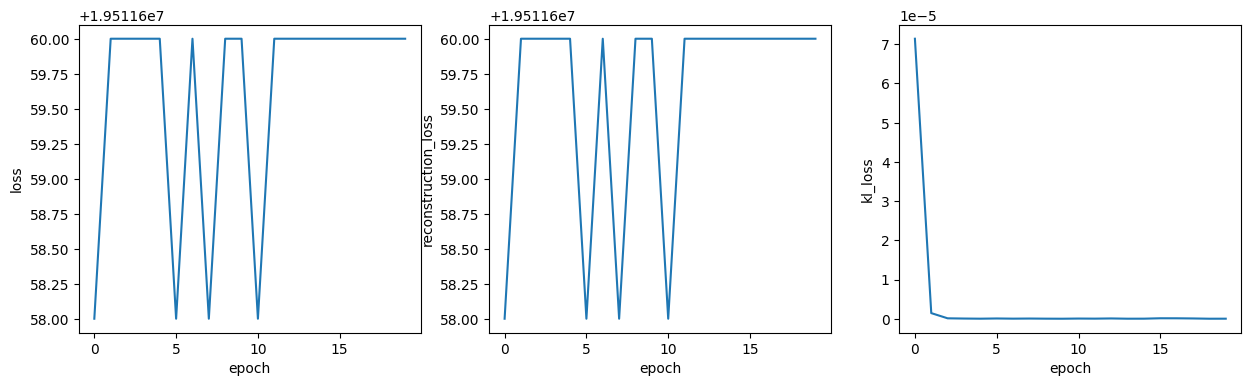

In [6]:
# 結果のプロット

row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [10]:
# 楽曲の復元

from scipy.io.wavfile import write

def ConvertToInt16Array(arr):
    return (arr * (np.iinfo(np.int16).max - np.iinfo(np.int16).min) + np.iinfo(np.int16).min).astype(np.int16)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.built = True
vae.load_weights("../data/models/vae")

index = 300
x = digits[index]
x = np.expand_dims(x, 0)
x_decode = vae.predict(x)

write("../data/out/original.wav", rate=sampling_rate, data=ConvertToInt16Array(x[0]))
write("../data/out/out.wav", rate=sampling_rate, data=ConvertToInt16Array(x_decode[0]))

1/1 [==============================] - 0s 26ms/step


In [13]:
x_decode[0][100:200]

array([[0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.49975184],
       [0.499

In [12]:
 np.iinfo(np.int16).min

-32768